- [10.3.2 - Hierarchical MCMC computation of relative model probability (Two factories of coins)](#10.3.2---Hierarchical-MCMC-computation-of-relative-model-probability)   

## Chapter 10 - Model Comparision and Hierarchical Modelling

In [1]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import pymc3 as pmc
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mode
from theano.tensor import eq
from sklearn import preprocessing
from IPython.display import Image
from matplotlib import gridspec

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_rows', 45)

%matplotlib inline
plt.style.use('seaborn-white')

### 10.3.2 - Hierarchical MCMC computation of relative model probability

Coin is flipped nine times, resulting in six heads.

#### Model (Kruschke, 2015)

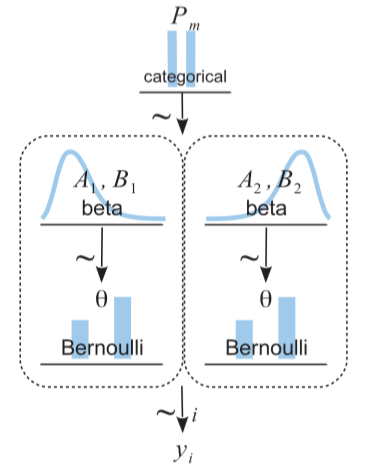

In [2]:
Image('images/fig10_2.png', width=300)

In [3]:
with pmc.Model() as hierarchical_model:
    m = pmc.Categorical('m', np.asarray([.5, .5]))
    
    kappa = 12
    omega = pmc.switch(eq(m, 0), .25, .75)
    
    theta = pmc.Beta('theta', omega*(kappa-2)+1, (1-omega)*(kappa-2)+1)
    
    y = pmc.Binomial('y', 9, theta, observed=6)    

Applied logodds-transform to theta and added transformed theta_logodds_ to model.


In [4]:
with hierarchical_model:
    step = pmc.NUTS()
     
    trace = pmc.sample(20000, step)

Assigned BinaryGibbsMetropolis to m
 [-----------------100%-----------------] 20000 of 20000 complete in 8.4 sec

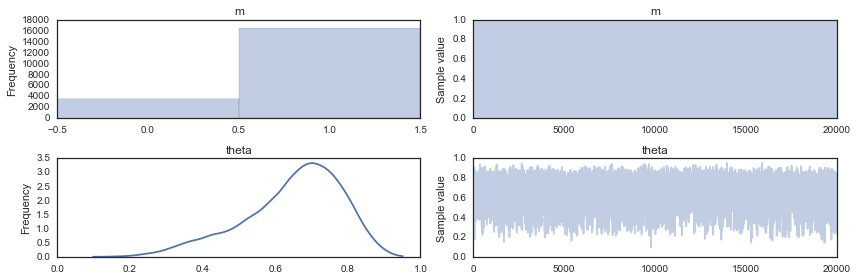

In [5]:
pmc.traceplot(trace);

In [6]:
trace_df = pmc.trace_to_dataframe(trace).set_index('m').drop('theta_logodds_', axis=1)
trace_df.head()

      theta
m          
1  0.520846
0  0.520846
1  0.450557
0  0.391185
1  0.515257

In [7]:
# modes per category m
trace_df.groupby(level=0).apply(lambda x: mode(np.round(x, decimals=2))[0][0])

m
0    [0.42]
1    [0.71]
dtype: object

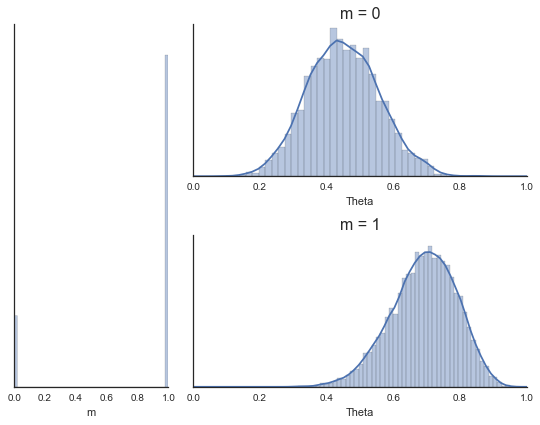

In [8]:
plt.figure(figsize=(10,6))

# Define gridspec
gs = gridspec.GridSpec(2, 4)
ax1 = plt.subplot(gs[0:,1])
ax2 = plt.subplot(gs[0,2:])
ax3 = plt.subplot(gs[1,2:])

sns.distplot(trace_df.index, kde=False, ax=ax1)
ax1.set_yticklabels([])
sns.despine(ax=ax1)

font_d = {'size':16}
sns.distplot(trace_df.loc[0], ax = ax2)
ax2.set_title('m = 0', fontdict=font_d)
sns.distplot(trace_df.loc[1], ax = ax3)
ax3.set_title('m = 1', fontdict=font_d)

for ax in [ax2, ax3]:
    ax.set(xlim=(0,1), xlabel='Theta')
    ax.yaxis.set_visible(False)
    sns.despine(ax=ax)

plt.tight_layout();